# BCM-DTI


# 1 STEP- COMPARING MY RESULTS WITH THOSE IN THE LITERATURE

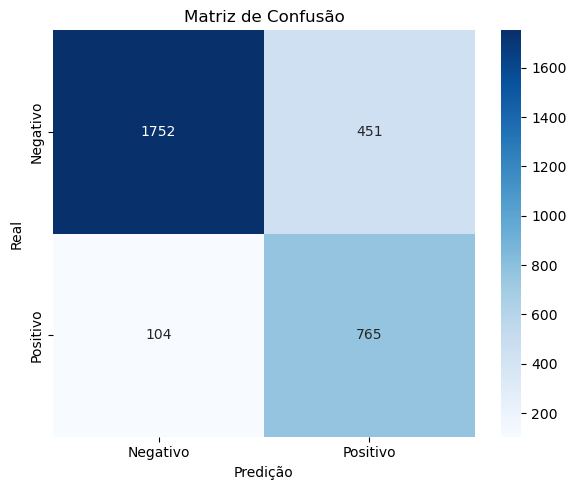

,Valor
AUROC,0.9080
AUPRC,0.7949
Recall,0.6291
Precision,0.8803
F1 Score,0.7360
Loss,0.3463
Accuracy,0.8193


/tmp/ipykernel_1386587/214043143.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_metrics.index, y="Valor", data=df_metrics, palette="viridis")


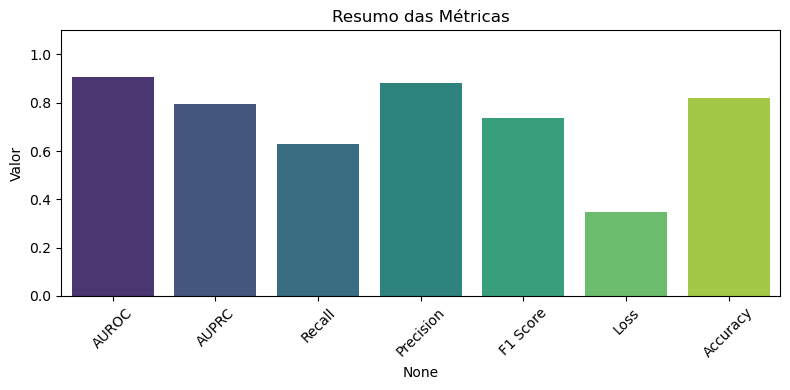

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

confusion_matrix = np.array([[1752,  451],
                             [  104,  765]])
metrics = {
    "AUROC": 0.9080,
    "AUPRC": 0.7949,
    "Recall": 0.6291,
    "Precision":0.8803,
    "F1 Score": 0.7360,
    "Loss": 0.3463,
    "Accuracy": 0.8193
}

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.title("Matriz de Confusão")
plt.xlabel("Predição")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

df_metrics = pd.DataFrame.from_dict(metrics, orient='index', columns=["Valor"])
df_metrics = df_metrics.round(4)
display(df_metrics)

plt.figure(figsize=(8, 4))
sns.barplot(x=df_metrics.index, y="Valor", data=df_metrics, palette="viridis")
plt.ylim(0, 1.1)
plt.title("Resumo das Métricas")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 2 STEP- Results of training model whit my datasets

# Papyrus

In [ ]:
import pandas as pd

def generate_data_txt_from_csv(csv_path, output_path):
    df = pd.read_csv(csv_path)

    with open(output_path, 'w', encoding='utf-8') as f:
        for _, row in df.iterrows():
            line = f"{row['smiles']} {row['sequence']} {int(row['label'])} {row['split']}\n"
            f.write(line)

    print(f"✓ Arquivo 'data.txt' criado em {output_path}")


generate_data_txt_from_csv("/home/resperanca/Tuberculosis_Tese/Data/DTI_Data_2_step/Papyrus_Barlow.csv", "/home/resperanca/Tuberculosis_Tese/Source/Models/BCM-DTI/data/Papyrus/data.txt")


✓ Arquivo 'data.txt' criado em /home/resperanca/Tuberculosis_Tese/Source/Models/BCM-DTI/data/Papyrus/data.txt


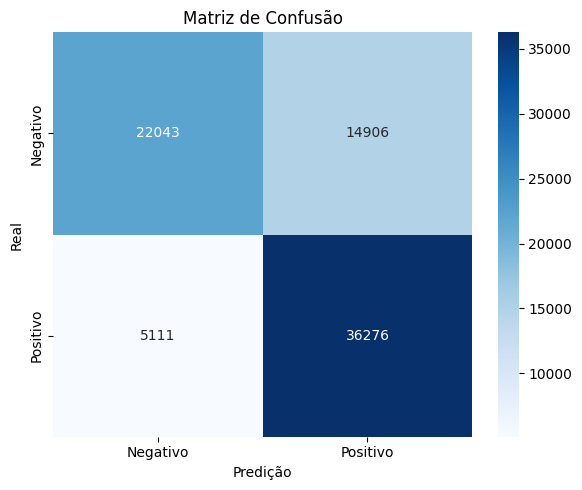

,Valor
AUROC,0.8248
AUPRC,0.8213
Precision,0.8765
Recall,0.7087
F1 Score,0.7701
Loss,0.5687


/tmp/ipykernel_3493901/63271854.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_metrics.index, y="Valor", data=df_metrics, palette="viridis")


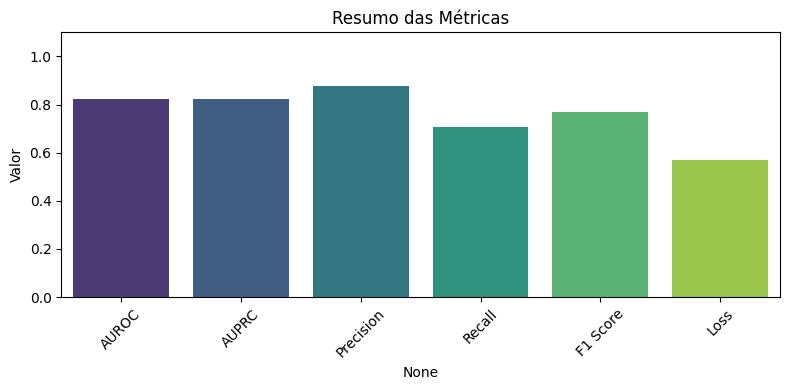

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

confusion_matrix = np.array([[22043, 14906],
                             [ 5111, 36276]])
metrics = {
    "AUROC": 0.8248,
    "AUPRC": 0.8213,
    "Precision": 0.8765,
    "Recall": 0.7087,
    "F1 Score": 0.7701,
    "Loss": 0.5687
}


plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.title("Matriz de Confusão")
plt.xlabel("Predição")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


df_metrics = pd.DataFrame.from_dict(metrics, orient='index', columns=["Valor"])
df_metrics = df_metrics.round(4)
display(df_metrics)

plt.figure(figsize=(8, 4))
sns.barplot(x=df_metrics.index, y="Valor", data=df_metrics, palette="viridis")
plt.ylim(0, 1.1)
plt.title("Resumo das Métricas")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Papyrus + TB

In [ ]:
import pandas as pd

def generate_data_txt_from_csv(csv_path, output_path):
    df = pd.read_csv(csv_path)

    with open(output_path, 'w', encoding='utf-8') as f:
        for _, row in df.iterrows():
            line = f"{row['smiles']} {row['sequence']} {int(row['label'])} {row['split']}\n"
            f.write(line)

    print(f"✓ Arquivo 'data.txt' criado em {output_path}")


generate_data_txt_from_csv("/home/resperanca/Tuberculosis_Tese/Data/DTI_Data_2_step/Papyrus_TB_Barlow.csv", "/home/resperanca/Tuberculosis_Tese/Source/Models/BCM-DTI/data/Papyrus_TB/data.txt")

✓ Arquivo 'data.txt' criado em /home/resperanca/Tuberculosis_Tese/Source/Models/BCM-DTI/data/Papyrus_TB/data.txt


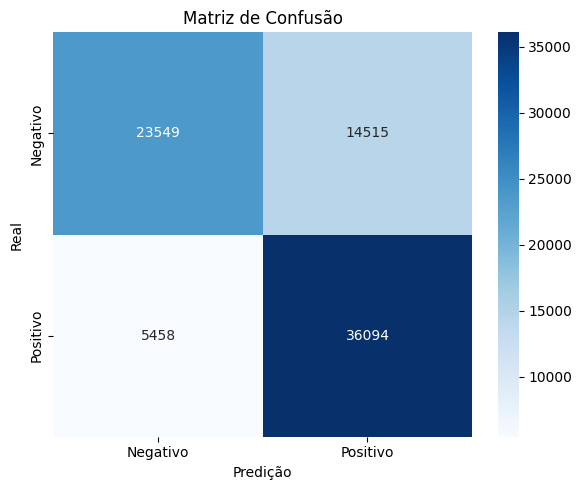

,Valor
AUROC,0.8309
AUPRC,0.8257
Precision,0.8686
Recall,0.7131
F1 Score,0.7524
Loss,0.5196


/tmp/ipykernel_4079241/568708483.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_metrics.index, y="Valor", data=df_metrics, palette="viridis")


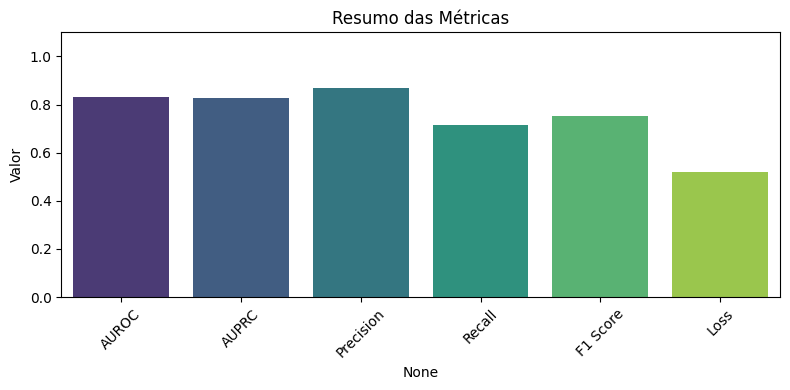

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

confusion_matrix = np.array([[23549, 14515],
                             [ 5458, 36094]])
metrics = {
    "AUROC": 0.8309,
    "AUPRC": 0.8257,
    "Precision": 0.8686,
    "Recall": 0.7131,
    "F1 Score": 0.7524,
    "Loss": 0.5196
}


plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.title("Matriz de Confusão")
plt.xlabel("Predição")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

df_metrics = pd.DataFrame.from_dict(metrics, orient='index', columns=["Valor"])
df_metrics = df_metrics.round(4)
display(df_metrics)

plt.figure(figsize=(8, 4))
sns.barplot(x=df_metrics.index, y="Valor", data=df_metrics, palette="viridis")
plt.ylim(0, 1.1)
plt.title("Resumo das Métricas")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Tuberculosis

In [ ]:
import pandas as pd

def generate_data_txt_from_csv(csv_path, output_path):
    df = pd.read_csv(csv_path)

    with open(output_path, 'w', encoding='utf-8') as f:
        for _, row in df.iterrows():
            line = f"{row['smiles']} {row['sequence']} {int(row['label'])} {row['split']}\n"
            f.write(line)

    print(f"✓ Arquivo 'data.txt' criado em {output_path}")


generate_data_txt_from_csv("/home/resperanca/Tuberculosis_Tese/Data/Tuberculosis_Data/tb_fina_BARLOW.csv", "/home/resperanca/Tuberculosis_Tese/Source/Models/BCM-DTI/data/TB/data.txt")

✓ Arquivo 'data.txt' criado em /home/resperanca/Tuberculosis_Tese/Source/Models/BCM-DTI/data/TB/data.txt


In [ ]:
import sys
sys.path.append("/home/resperanca/Tuberculosis_Tese/Source/Models/BCM-DTI/")

from SSCNN_utils import *
import numpy as np


input_path = "/home/resperanca/Tuberculosis_Tese/Source/Models/BCM-DTI/data/TB"
k = 3  

train_smiles, train_prot, train_label, \
val_smiles, val_prot, val_label, \
test_smiles, test_prot, test_label = load_all_dataset_by_split(input_path)


all_smiles = train_smiles + val_smiles + test_smiles
all_proteins = train_prot + val_prot + test_prot
all_labels = train_label + val_label + test_label


bcm_smiles, cat_proteins, _ = get_one_bcm(all_smiles, all_proteins, all_labels, decompose2="category", k=k)


max_drug_len = max(len(s) for s in bcm_smiles)
unique_drug_tokens = set(t for s in bcm_smiles for t in s)

max_prot_len = max(len(p) for p in cat_proteins)
unique_prot_tokens = set(t for p in cat_proteins for t in p)


print("Papyrus_TB:")
print("max_drug_seq:", max_drug_len)
print("max_protein_seq:", max_prot_len)
print("input_d_dim:", len(unique_drug_tokens))
print("input_p_dim:", len(unique_prot_tokens))


Papyrus_TB:
max_drug_seq: 44
max_protein_seq: 462
input_d_dim: 5620
input_p_dim: 206


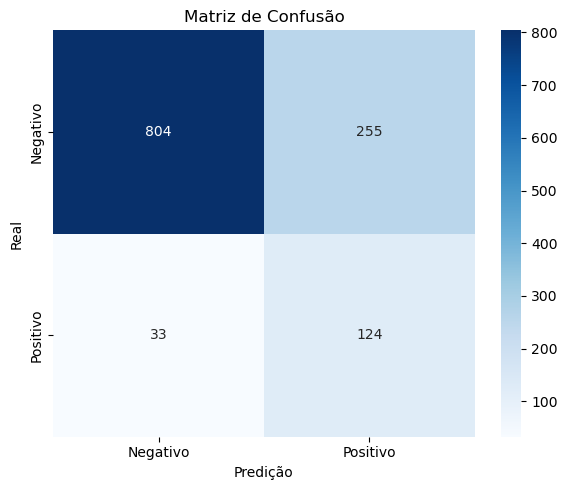

,Valor
AUROC,0.8348
AUPRC,0.4163
Precision,0.7898
Recall,0.3271
F1 Score,0.3004
Loss,0.2951


/tmp/ipykernel_4148331/1620422012.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_metrics.index, y="Valor", data=df_metrics, palette="viridis")


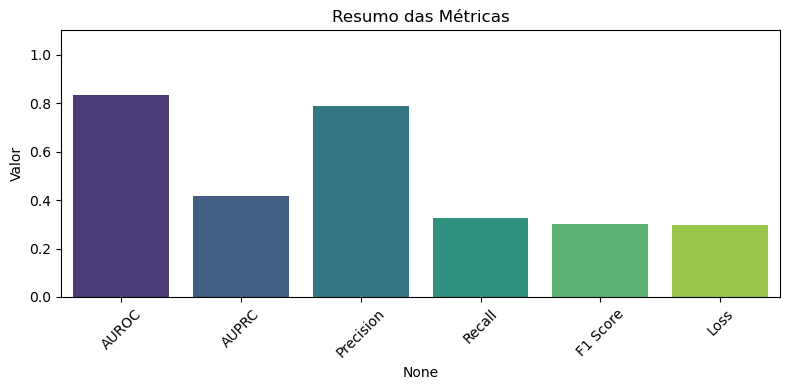

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

confusion_matrix = np.array([[804, 255],
                             [ 33, 124]])
metrics = {
    "AUROC": 0.8348,
    "AUPRC": 0.4163,
    "Precision": 0.7898,
    "Recall": 0.3271,
    "F1 Score": 0.3004,
    "Loss": 0.2951
}

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.title("Matriz de Confusão")
plt.xlabel("Predição")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

df_metrics = pd.DataFrame.from_dict(metrics, orient='index', columns=["Valor"])
df_metrics = df_metrics.round(4)
display(df_metrics)

plt.figure(figsize=(8, 4))
sns.barplot(x=df_metrics.index, y="Valor", data=df_metrics, palette="viridis")
plt.ylim(0, 1.1)
plt.title("Resumo das Métricas")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Fine-tuning

### Fine tuning—adapting the pre-trained BCM-DTI model, originally trained with the Papyrus dataset, to the specific context of predicting drug-protein interactions associated with tuberculosis. The model's performance was evaluated on the tuberculosis test dataset, before and after fine tuning.

In [ ]:

n = 2  

args['d_channel_size'] = args['d_channel_size'][n]
args['p_channel_size'] = args['p_channel_size'][n]
print(args['d_channel_size'])  
print(args['p_channel_size']) 


[25, 128, 256, 512]
[462, 128, 256, 512]


In [ ]:
from SSCNN_train import test
import pickle

import torch
from SSCNN_model import SSCNN_DTI
from SSCNN_utils import load_train_val_test_set
from SSCNN_dataset import NewDataset
from torch.utils.data import DataLoader

args = SSCNN_args()
args['max_drug_seq'] = 44
args['max_protein_seq'] = 462
args['input_d_dim'] = len(words2idx_d_old) + 1
args['input_p_dim'] = len(words2idx_p_old) + 1
args['d_channel_size'][2][0] = args['max_drug_seq'] 
args['p_channel_size'][2][0] = args['max_protein_seq']
args['d_channel_size'] = args['d_channel_size'][2]
args['p_channel_size'] = args['p_channel_size'][2]
args['dataset_name'] = "TB"

model = SSCNN_DTI(args)
model.load_state_dict(torch.load("/home/resperanca/Tuberculosis_Tese/Source/Models/model/TB/7.pkl"))
model.to("cuda")

with open("/home/resperanca/Tuberculosis_Tese/Source/Models/BCM-DTI/words2idx_d_papyrus.pkl", "rb") as f:
    words2idx_d = pickle.load(f)

with open("/home/resperanca/Tuberculosis_Tese/Source/Models/BCM-DTI/words2idx_p_papyrus.pkl", "rb") as f:
    words2idx_p = pickle.load(f)

input_path = "/home/resperanca/Tuberculosis_Tese/Source/Models/BCM-DTI/data/TB"
trainSmiles, trainProtein, trainLabel, \
valSmiles, valProtein, valLabel, \
testSmiles, testProtein, testLabel, \
frag_set_d, frag_set_p, \
frag_len_d, frag_len_p, _, _ = load_train_val_test_set(
    input_path, decompose="bcm", decompose_protein="category",
    unseen_smiles=False, k=3, 
)

testDataset = NewDataset(testSmiles, testProtein, testLabel, words2idx_d, words2idx_p, args['max_drug_seq'], args['max_protein_seq'])
test_loader = DataLoader(testDataset, batch_size=args['batch_size'], shuffle=False)

model.eval()
with torch.no_grad():
    auc, auprc, acc, recall, precision, f1, logits, loss = test(test_loader, model)

print(f"\nResultados do modelo fine-tuned (7.pkl) no dataset TB:\n"
      f"AUROC: {auc:.4f}\n"
      f"AUPRC: {auprc:.4f}\n"
      f"Precisão: {precision:.4f}\n"
      f"Recall: {recall:.4f}\n"
      f"F1 Score: {f1:.4f}\n"
      f"Acurácia: {acc:.4f}\n"
      f"Loss: {loss:.4f}\n")


AUROC:0.8168270938804512
AUPRC: 0.3874375720970276
Confusion Matrix : 
 [[696 416]
 [ 23 139]]
Recall :  0.8580246913580247
Precision :  0.25045045045045045
Accuracy :  0.6554160125588697
Sensitivity :  0.6258992805755396
Specificity :  0.8580246913580247

Resultados do modelo fine-tuned (7.pkl) no dataset TB:
AUROC: 0.8168
AUPRC: 0.3874
Precisão: 0.2505
Recall: 0.8580
F1 Score: 0.3504
Acurácia: 0.6554
Loss: 0.3131



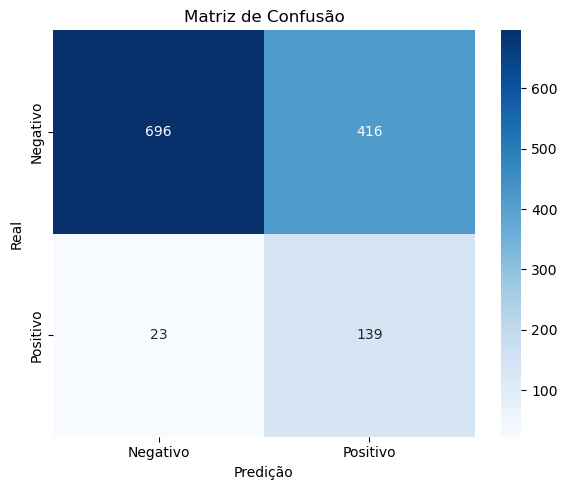

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

confusion_matrix = np.array([[696,  416],
                             [  23,  139]])


plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.title("Matriz de Confusão")
plt.xlabel("Predição")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

### In the model trained with the Papyrus dataset, we also obtained good results, but it is necessary to understand if the tuberculosis metrics are really good or if the model metrics in general are good. 

## tuberculosis metrics: 

In [ ]:
import pandas as pd
import json
import sys, json, torch, pickle
sys.path.append("/home/resperanca/Tuberculosis_Tese/Source/Models/BCM-DTI_normal")
from SSCNN_dataset import NewDataset
from SSCNN_model import SSCNN_DTI
from torch.utils.data import DataLoader
from sklearn.metrics import matthews_corrcoef
from SSCNN_utils import get_one_bcm
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, f1_score, precision_score, recall_score
)
import numpy as np



df = pd.read_csv("/home/resperanca/Tuberculosis_Tese/Data/DTI_Data_2_step/metricstb.csv")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open("/home/resperanca/Tuberculosis_Tese/Source/Models/BCM-DTI_normal/model/Papyrus_TB/vocab/words2idx_d_Papyrus_TB.pkl","rb") as f:
    words2idx_d = pickle.load(f)
with open("/home/resperanca/Tuberculosis_Tese/Source/Models/BCM-DTI_normal/model/Papyrus_TB/vocab/words2idx_p_Papyrus_TB.pkl","rb") as f:
    words2idx_p = pickle.load(f)
max_drug_seq = 44
max_prot_seq = 462

smiles_list = df["smiles"].tolist()
prot_list   = df["sequence"].tolist()


if "label" not in df.columns:
    raise ValueError("A coluna 'label' não existe no CSV. Ajuste para o nome correto da sua coluna de rótulos.")
labels_real = df["label"]


mask_valid = labels_real.notna()
if not mask_valid.all():
    df = df.loc[mask_valid].reset_index(drop=True)
    smiles_list = df["smiles"].tolist()
    prot_list   = df["sequence"].tolist()
    labels_real = df["label"].reset_index(drop=True)

labels_real = labels_real.astype(int).clip(0,1).tolist()

sm_frag, pr_frag, _ = get_one_bcm(smiles_list, prot_list, labels_real, decompose2="category", k=3)

with open("/home/resperanca/Tuberculosis_Tese/Source/Models/BCM-DTI_normal/model/Papyrus_TB/config_Papyrus_TB.json") as f:
    args_config = json.load(f)

dataset_inf = NewDataset(sm_frag, pr_frag, labels_real, words2idx_d, words2idx_p, max_drug_seq, max_prot_seq)
loader_inf  = DataLoader(dataset_inf, batch_size=64, shuffle=False)

model = SSCNN_DTI(args_config)
model.load_state_dict(torch.load("/home/resperanca/Tuberculosis_Tese/Source/Models/BCM-DTI_normal/model/Papyrus_TB/34.pkl", map_location=device))
model.to(device).eval()

scores = []
with torch.no_grad():
    for d, _, p, _ in loader_inf:
        out = model(d.long().to(device), p.long().to(device)) 
        s = out.squeeze()

        if (s.min() < 0) or (s.max() > 1):
            s = torch.sigmoid(s)

        scores.extend(s.detach().cpu().numpy().tolist())


y_true  = np.array(labels_real, dtype=int)
y_score = np.array(scores, dtype=float)


y_pred = (y_score >= 0.5).astype(int)

has_both_classes = (y_true.min() != y_true.max())

metrics = {}
if has_both_classes:
    metrics["AUC"]   = float(roc_auc_score(y_true, y_score))
    metrics["AP"]    = float(average_precision_score(y_true, y_score))  # PR-AUC
else:
    metrics["AUC"] = None
    metrics["AP"]  = None

metrics["Accuracy"]  = float(accuracy_score(y_true, y_pred))
metrics["F1"]        = float(f1_score(y_true, y_pred, zero_division=0))
metrics["Precision"] = float(precision_score(y_true, y_pred, zero_division=0))
metrics["Recall"]    = float(recall_score(y_true, y_pred, zero_division=0))
mcc = matthews_corrcoef(y_true, y_pred)
metrics["MCC"] = float(mcc)

for k,v in metrics.items():
    print(f"{k}: {v:.4f}" if isinstance(v,float) else f"{k}: {v}")

df_out = df.copy()
df_out["score_bcmdti"] = y_score
df_out["pred_bcmdti"]  = y_pred
df_out.to_csv("predicoes_bcmdti4.csv", index=False)

with open("metricas_bcmdti4.json", "w") as f:
    json.dump(metrics, f, indent=2)